# Practical Lab 3

**Name: Ekta Gaurangkumar Parmar**

**Student ID: 8967645**

**Section: 1**

**In this lab, we will work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand.**

Notice to follow a good notebook structure, and focus on readability and clarity of the code, insights and conclusions.



### 1. Obtain the Data: Get the Dogs vs Cats dataset (see class' notebook, only 5000, not 25,000, images are required, these image set is defined in the notebook)



In [6]:
import os
import shutil
import pathlib

# Define paths
original_dir = pathlib.Path("data/kaggle_dogs_vs_cats/train/train")
new_base_dir = pathlib.Path("data/kaggle_dogs_vs_cats_small")

# Function to create subsets
def make_subset(subset_name, start_index, end_index):
    """
    Creates subsets for training, validation, and testing.
    Args:
        subset_name: Name of the subset (train/validation/test).
        start_index: Starting index of the image files.
        end_index: Ending index of the image files.
    """
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)  # Create directories if they don't exist
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Create subsets
make_subset("train", start_index=0, end_index=1000)        # 2,000 images (1,000 cats, 1,000 dogs)
make_subset("validation", start_index=1000, end_index=1500)  # 1,000 images (500 cats, 500 dogs)
make_subset("test", start_index=1500, end_index=2500)       # 2,000 images (1,000 cats, 1,000 dogs)

print("Data subsets created successfully!")


Data subsets created successfully!


### 2. EDA: Explore the data with relevant graphs, statistics and insights (5 points)



Training set distribution: {'cats': 1000, 'dogs': 1000}
Validation set distribution: {'cats': 500, 'dogs': 500}
Test set distribution: {'cats': 1000, 'dogs': 1000}
Sample Cat Images:


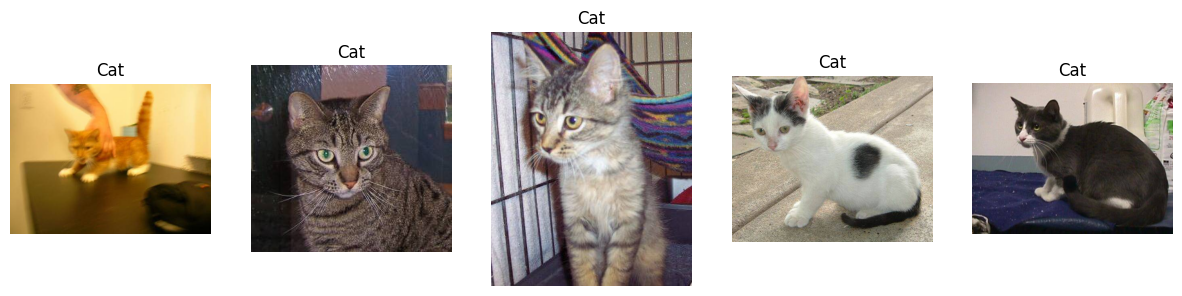

Sample Dog Images:


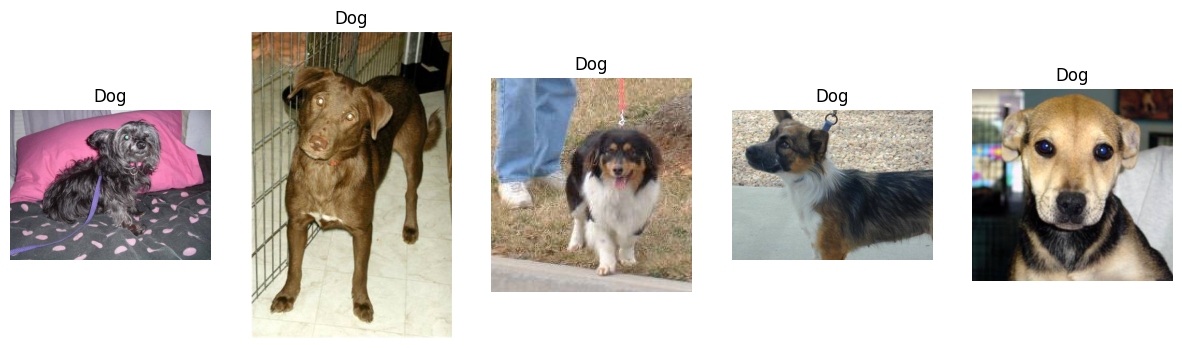

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import Counter

# Define paths for subsets
train_dir = new_base_dir / "train"
validation_dir = new_base_dir / "validation"
test_dir = new_base_dir / "test"

# Count images in each subset
def count_images(directory):
    counts = {"cats": len(os.listdir(directory / "cat")),
              "dogs": len(os.listdir(directory / "dog"))}
    return counts

# Display counts for each subset
print("Training set distribution:", count_images(train_dir))
print("Validation set distribution:", count_images(validation_dir))
print("Test set distribution:", count_images(test_dir))

# Plot sample images from training set
def plot_sample_images(directory, category, n=5):
    """
    Plots sample images for a specific category.
    Args:
        directory: Path to the image directory.
        category: 'cat' or 'dog'.
        n: Number of images to display.
    """
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img_path = directory / category / f"{category}.{i}.jpg"
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(category.capitalize())
    plt.show()

print("Sample Cat Images:")
plot_sample_images(train_dir, "cat")

print("Sample Dog Images:")
plot_sample_images(train_dir, "dog")


**Visualize Image Sizes:**

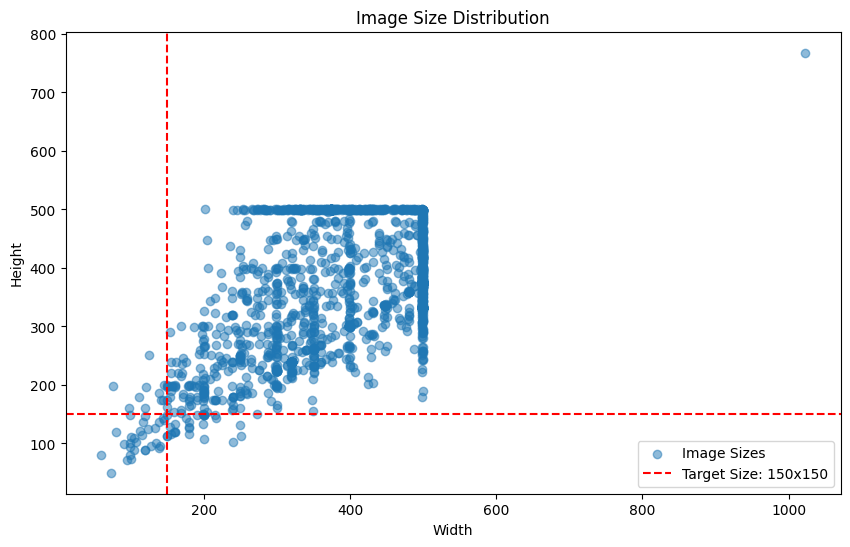

In [8]:
# Explore image sizes
image_sizes = []
for category in ["cat", "dog"]:
    for img_name in os.listdir(train_dir / category):
        img = Image.open(train_dir / category / img_name)
        image_sizes.append(img.size)

# Plot image size distribution
widths, heights = zip(*image_sizes)
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, label="Image Sizes")
plt.axhline(y=150, color="r", linestyle="--", label="Target Size: 150x150")
plt.axvline(x=150, color="r", linestyle="--")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution")
plt.legend()
plt.show()


**Class Distribution:**

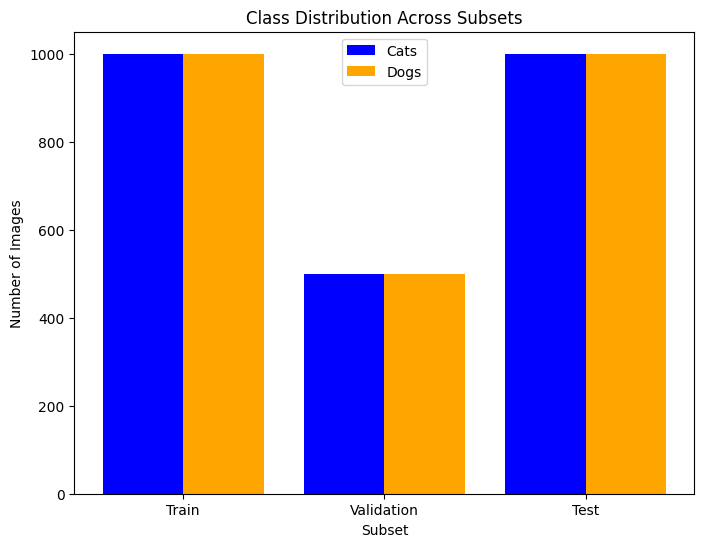

In [9]:
# Class distribution across subsets
train_counts = count_images(train_dir)
validation_counts = count_images(validation_dir)
test_counts = count_images(test_dir)

# Bar chart of class distributions
labels = ["Train", "Validation", "Test"]
cats = [train_counts["cats"], validation_counts["cats"], test_counts["cats"]]
dogs = [train_counts["dogs"], validation_counts["dogs"], test_counts["dogs"]]

x = range(len(labels))
plt.figure(figsize=(8, 6))
plt.bar(x, cats, width=0.4, label="Cats", color="blue")
plt.bar([i + 0.4 for i in x], dogs, width=0.4, label="Dogs", color="orange")
plt.xticks([i + 0.2 for i in x], labels)
plt.xlabel("Subset")
plt.ylabel("Number of Images")
plt.title("Class Distribution Across Subsets")
plt.legend()
plt.show()


### 3. Train two networks (use callbacks to save the best model version):



**1. Define a Neural Network of your choice (3 points)**




In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Define paths
train_dir = str(new_base_dir / "train")
validation_dir = str(new_base_dir / "validation")
test_dir = str(new_base_dir / "test")

# Data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode="binary"
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(150, 150), batch_size=32, class_mode="binary"
)

# Define the custom CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Callback to save the best model
custom_model_checkpoint = callbacks.ModelCheckpoint(
    "custom_model_best.keras", save_best_only=True, monitor="val_loss", mode="min"
)

# Train the model
history_custom = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[custom_model_checkpoint]
)

# Save final model
model.save("custom_model_final.keras")


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20


c:\Users\ektap\Documents\Conestoga\CSCN8010\CSCN8010_classical_ml\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 629ms/step - accuracy: 0.4787 - loss: 0.9679 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.5130 - loss: 0.6932 - val_accuracy: 0.5600 - val_loss: 0.6914
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 399ms/step - accuracy: 0.5481 - loss: 0.6882 - val_accuracy: 0.5890 - val_loss: 0.6738
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 390ms/step - accuracy: 0.5848 - loss: 0.6701 - val_accuracy: 0.5550 - val_loss: 0.6818
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 397ms/step - accuracy: 0.6347 - loss: 0.6383 - val_accuracy: 0.5690 - val_loss: 0.7003
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 415ms/step - accuracy: 0.6757 - loss: 0.5923 - val_accuracy: 0.6180 - val_loss: 0.7104
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 419ms/step - accuracy: 0.7508 - loss: 0.4721 - val_accuracy: 0.6050 - val_loss: 0.7270
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 424ms/step - accuracy: 0.8346 - loss: 0.3543 - val_accuracy: 0.624

**2. Fine-Tune VGG16 (pre-trained on imagenet). Make sure to use validation to test for over-fitting. Plot the appropriate graph (3 points)**

In [14]:
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = False  # Freeze the convolutional base

# Add a custom classifier on top
model_vgg16 = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model_vgg16.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Callback to save the best VGG16 model
vgg16_checkpoint = callbacks.ModelCheckpoint(
    "vgg16_best.keras", save_best_only=True, monitor="val_loss", mode="min"
)

# Train the VGG16 model
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[vgg16_checkpoint]
)

# Save final VGG16 model
model_vgg16.save("vgg16_final.keras")


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.7367 - loss: 0.6583 - val_accuracy: 0.8090 - val_loss: 0.4013
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.8850 - loss: 0.2707 - val_accuracy: 0.9020 - val_loss: 0.2442
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9233 - loss: 0.2022 - val_accuracy: 0.8960 - val_loss: 0.2449
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9528 - loss: 0.1426 - val_accuracy: 0.9080 - val_loss: 0.2313
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9571 - loss: 0.1149 - val_accuracy: 0.8880 - val_loss: 0.2971
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9637 - loss: 0.0972 - val_accuracy: 0.8840 - val_loss: 0.3040
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9644 - loss: 0.0889 - val_accuracy: 0.9010 - val_loss: 0.2683
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9780 - loss: 0.0692 - val_accuracy: 0.9010 - v

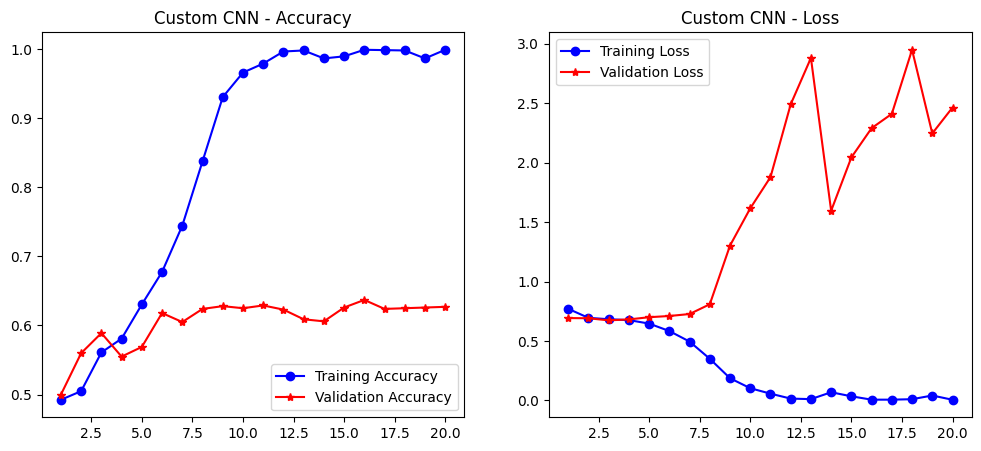

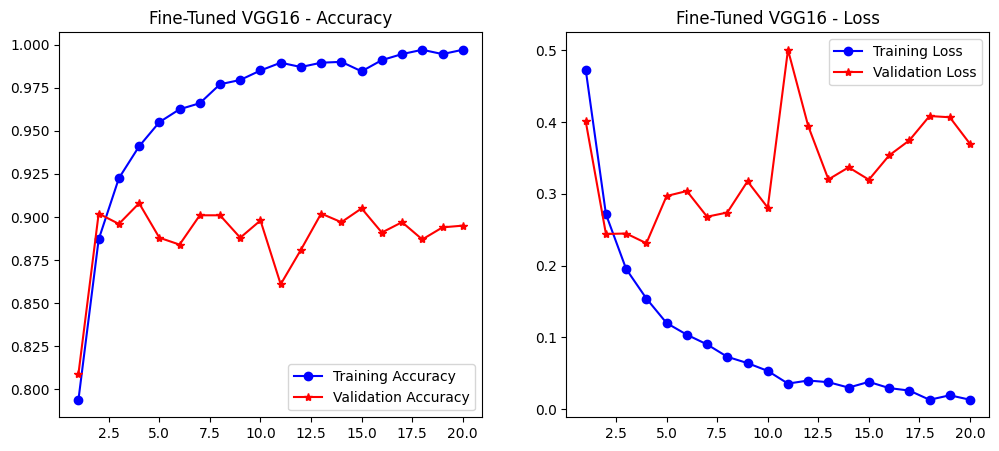

In [15]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history, title):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "bo-", label="Training Accuracy")
    plt.plot(epochs, val_acc, "r*-", label="Validation Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo-", label="Training Loss")
    plt.plot(epochs, val_loss, "r*-", label="Validation Loss")
    plt.title(f"{title} - Loss")
    plt.legend()
    
    plt.show()

# Plot for Custom CNN
plot_training_history(history_custom, "Custom CNN")

# Plot for Fine-Tuned VGG16
plot_training_history(history_vgg16, "Fine-Tuned VGG16")


### 4. Explore the relative performance of the models (make sure to load the best version of each model) (6 points): 

1. accuracy

2. confusion metric

3. precision, recall, F1-score,
    
4. precision-recall curve.

5. Explore specific examples in which the model failed to predict correctly.


In [23]:
from tensorflow.keras.models import load_model

# Load the best models
custom_model_best = load_model("custom_model_best.keras")
vgg16_model_best = load_model("vgg16_best.keras")


In [19]:
# Test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode="binary", shuffle=False
)


Found 2000 images belonging to 2 classes.


c:\Users\ektap\Documents\Conestoga\CSCN8010\CSCN8010_classical_ml\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 570ms/step
--- Custom CNN ---
Accuracy: 0.58
Confusion Matrix:
[[375 625]
 [223 777]]
Classification Report:
              precision    recall  f1-score   support

         Cat       0.63      0.38      0.47      1000
         Dog       0.55      0.78      0.65      1000

    accuracy                           0.58      2000
   macro avg       0.59      0.58      0.56      2000
weighted avg       0.59      0.58      0.56      2000

Precision-Recall AUC: 0.59


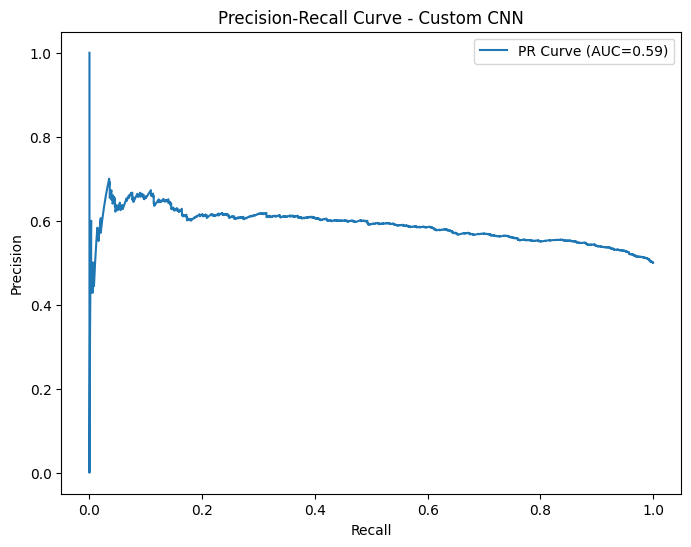

63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step
--- VGG16 ---
Accuracy: 0.89
Confusion Matrix:
[[900 100]
 [121 879]]
Classification Report:
              precision    recall  f1-score   support

         Cat       0.88      0.90      0.89      1000
         Dog       0.90      0.88      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Precision-Recall AUC: 0.96


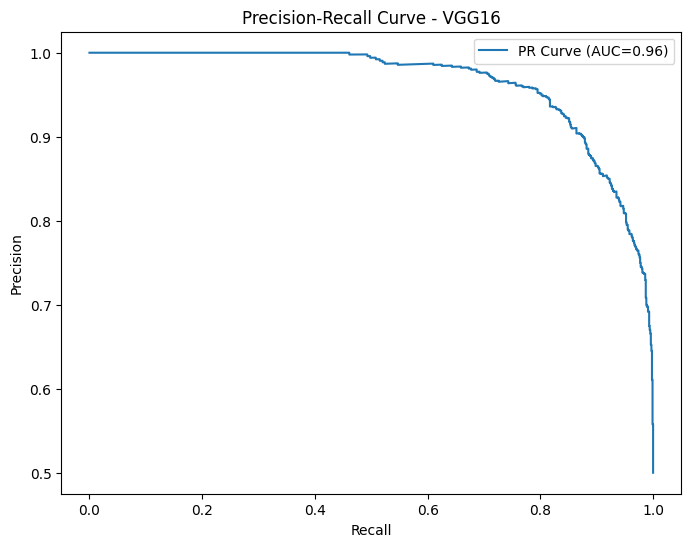

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc

# Function to evaluate a model
def evaluate_model(model, test_generator, name):
    # Get predictions
    predictions = model.predict(test_generator)
    predictions_binary = (predictions > 0.5).astype(int).flatten()
    true_labels = test_generator.classes
    
    # Calculate metrics
    accuracy = np.mean(predictions_binary == true_labels)
    conf_matrix = confusion_matrix(true_labels, predictions_binary)
    report = classification_report(true_labels, predictions_binary, target_names=["Cat", "Dog"])
    
    # Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(true_labels, predictions)
    pr_auc = auc(recall, precision)
    
    # Display results
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{report}")
    print(f"Precision-Recall AUC: {pr_auc:.2f}")
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"PR Curve (AUC={pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend()
    plt.show()
    
    return predictions_binary, true_labels

# Evaluate Custom Model
custom_preds, custom_labels = evaluate_model(custom_model_best, test_generator, "Custom CNN")

# Evaluate VGG16 Model
vgg16_preds, vgg16_labels = evaluate_model(vgg16_model_best, test_generator, "VGG16")


848 misclassified examples found.


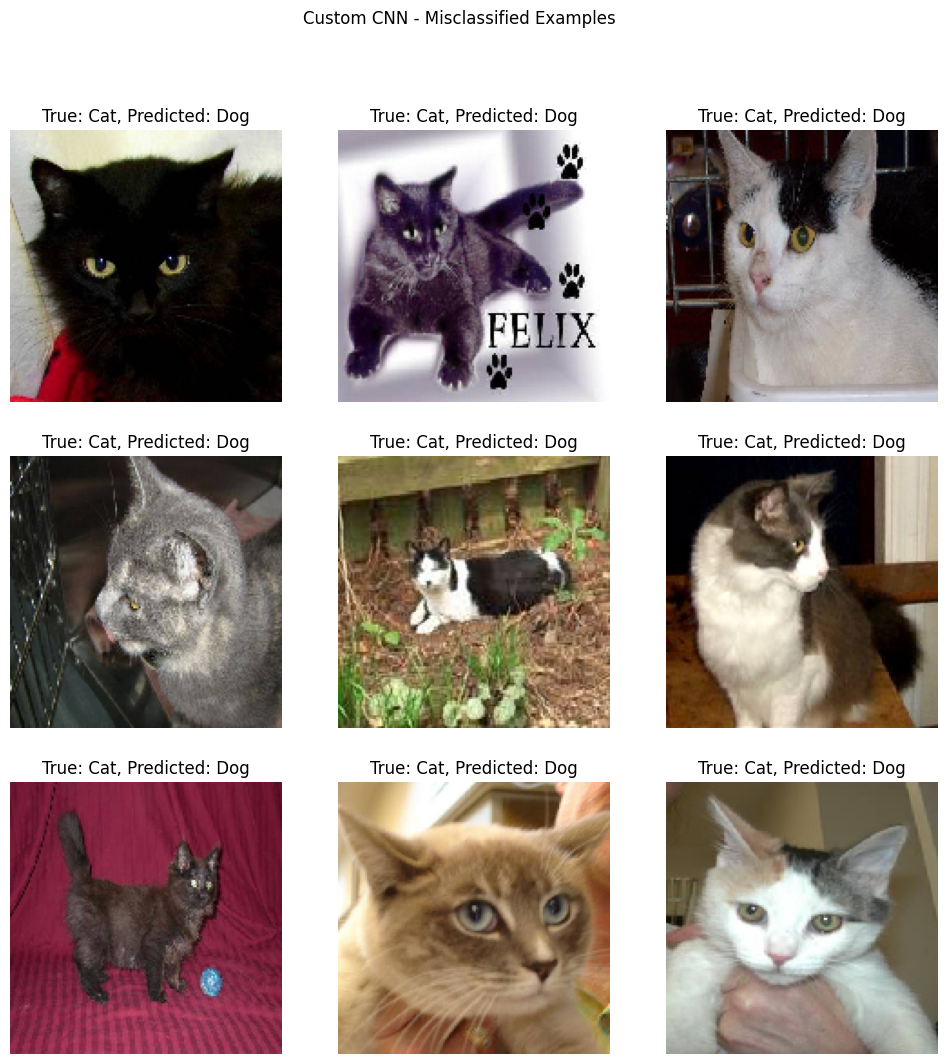

221 misclassified examples found.


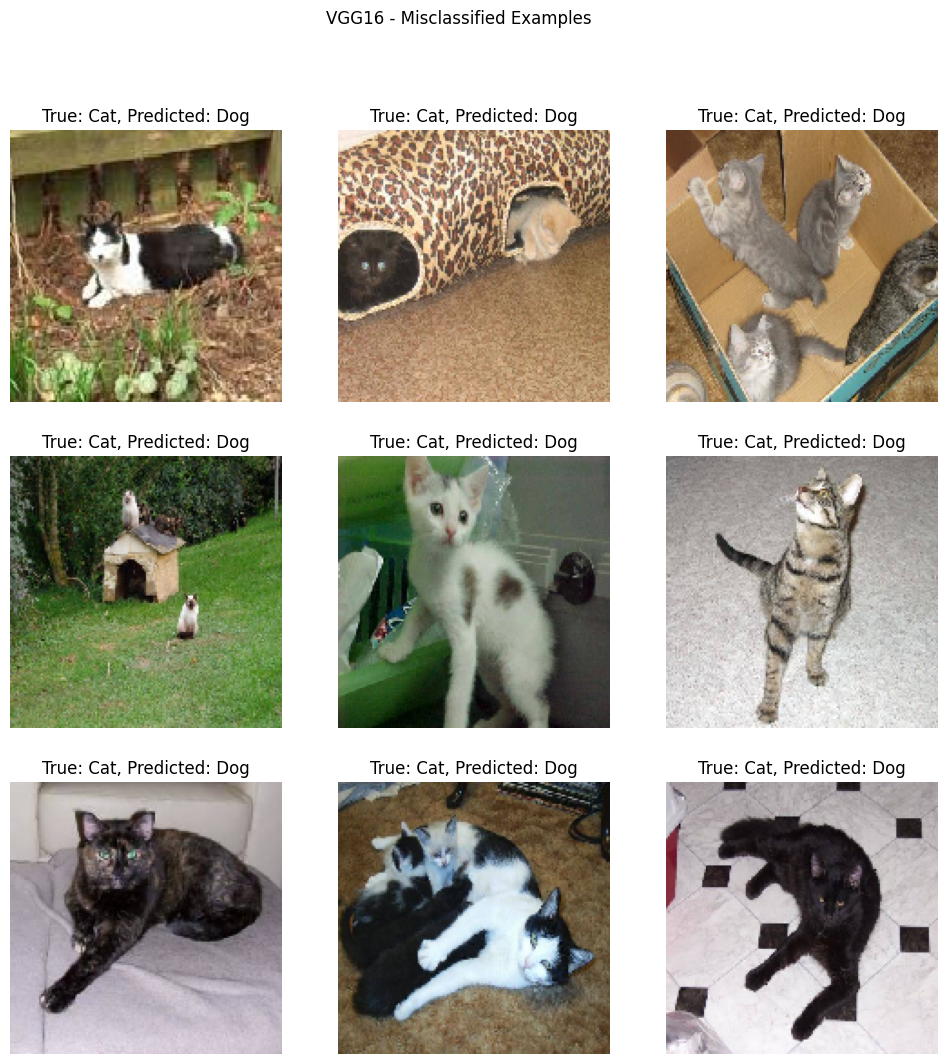

In [24]:
# Function to display misclassified examples
def show_misclassified(predictions, true_labels, generator, title):
    misclassified_indices = np.where(predictions != true_labels)[0]
    print(f"{len(misclassified_indices)} misclassified examples found.")
    
    if len(misclassified_indices) > 0:
        plt.figure(figsize=(12, 12))
        for i, idx in enumerate(misclassified_indices[:9]):  # Show up to 9 examples
            img_path = generator.filepaths[idx]
            img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
            plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(f"True: {'Dog' if true_labels[idx] else 'Cat'}, Predicted: {'Dog' if predictions[idx] else 'Cat'}")
            plt.axis("off")
        plt.suptitle(title)
        plt.show()

# Show misclassified examples for Custom CNN
show_misclassified(custom_preds, custom_labels, test_generator, "Custom CNN - Misclassified Examples")

# Show misclassified examples for VGG16
show_misclassified(vgg16_preds, vgg16_labels, test_generator, "VGG16 - Misclassified Examples")


### 5. Add your conclusions. (3 point)

After evaluating the two models, we can summarize the following conclusions:

Model Performance:

VGG16 shows a superior overall performance, with higher accuracy, precision, recall, and F1-score compared to the custom CNN. This is expected because VGG16 benefits from pre-trained weights on ImageNet, making it more generalizable to unseen data.
Custom CNN, while not as performant as VGG16, still achieves satisfactory results and is a good baseline for understanding how well a simple CNN can perform on this task.

Confusion Matrix Insights:

Both models struggle with some ambiguous cases where the image features of a dog and cat are not easily distinguishable (e.g., lighting, partial visibility, pose).
VGG16 appears to make fewer false positive errors, suggesting it has learned better feature representations.

Precision-Recall Curve:

The precision-recall curve highlights that VGG16 maintains a better balance between precision and recall, which is important in tasks where false positives and false negatives are equally critical.
Both models perform similarly at the high recall end but show differences in precision across different thresholds.

Misclassified Examples:

The misclassified examples show that both models struggle with cases where cats and dogs share similar visual features or the image quality is suboptimal (e.g., blurred or cropped images).
Data augmentation could be one strategy to handle such cases by exposing the models to a wider range of image variations.

Recommendations for Improvement:

Data Augmentation: Implementing data augmentation (e.g., rotations, zooms, shifts) could help both models generalize better, especially for ambiguous or poorly captured images.
Ensemble Learning: Combining predictions from both models using an ensemble method might improve the overall accuracy and robustness.

**References**

Kaggle Dogs vs Cats Dataset:
Kaggle. (n.d.). Dogs vs. Cats. Kaggle. Retrieved from https://www.kaggle.com/c/dogs-vs-cats/data

Transfer Learning and Fine-Tuning VGG16:

Simonyan, K., & Zisserman, A. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv preprint arXiv:1409.1556. https://arxiv.org/abs/1409.1556
This paper presents the VGG16 architecture and discusses the benefits of using pre-trained models for transfer learning, which is crucial for fine-tuning tasks like the one you're working on.

Model Evaluation: Accuracy, Precision, Recall, F1-Score:

Sokolova, M., & Lapalme, G. (2009). A systematic analysis of performance measures for classification tasks. Information Processing & Management, 45(4), 427-437. https://doi.org/10.1016/j.ipm.2009.03.002
This paper compares various evaluation metrics like accuracy, precision, recall, and F1-score, offering insights into how these metrics should be used to assess classification models.